# **High Dimensional Dynamic Stochastic Copula Model**

---

This notebook represents some of the work and results we obtained. All the clean implementations are in Script folder.

In this work we will : 

- Implement The model studied in the section 4. of the paper is defined as: $$ y^i_t = W^i_t \cdot \beta ^i _y + \gamma _y^i \cdot \delta ^i_t + \sqrt{\delta ^i_t} \cdot \exp(\frac{h^i_t} 2) \cdot \epsilon ^i_{y, t}$$ $$ h^i_{t+1} = \mu_h ^i + \phi_h ^i \cdot (h_t^i - \mu_h ^i)+ \sigma _h ^i \cdot \epsilon _{h,t} ^i $$
where $$ \epsilon ^i_{\cdot, t} \sim \mathcal N(0,1)$$ $$\delta ^i _t \sim \text{Inv-Gamma}(\frac{\nu_y ^i} 2, \frac{\nu_y ^i} 2)$$ $$W^i _t = (1, y^i_{t-1}, \dots, y^i_{t-k}) $$ with $k=3, 5$ depending on the type of the series studied ($3$ for equities series and $5$ for credit default swap series). We assume moreover that $$\text{Corr}(\epsilon ^i_{y, t}, \epsilon ^i_{h, t}) = \rho^i$$

- Implement Bootstrap Particle Filter and apply it to simulated data from the model.
- Implement the Particle Gibbs Sampler to simulate the paths of factor loadings of the latent space of the copula model.
- Apply the Particle Gibbs Sampler to real data (S&P500 returns), which we will obtain using yahou finance API.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('dark_background')
import seaborn as sns
import pandas as pd
import plotly
import sklearn
import particles 
import particles.state_space_models as ssm
import particles.distributions as dists
from tqdm.notebook import tqdm

## Particles Library : Toy Example

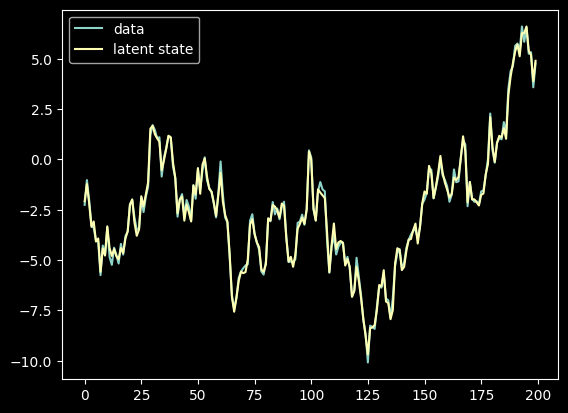

In [2]:
import particles
import particles.state_space_models as ssm
import particles.distributions as dists

class ToySSM(ssm.StateSpaceModel):
    def PX0(self):  # Distribution of X_0 
        return dists.Normal()  # X_0 ~ N(0, 1)
    def PX(self, t, xp):  # Distribution of X_t given X_{t-1}
        return dists.Normal(loc=xp)  # X_t ~ N( X_{t-1}, 1)
    def PY(self, t, xp, x):  # Distribution of Y_t given X_t (and X_{t-1}) 
        return dists.Normal(loc=x, scale=self.sigma)  # Y_t ~ N(X_t, sigma^2)
    

my_model = ToySSM(sigma=0.2)
x, y = my_model.simulate(200)  # sample size is 200
plt.plot(y, label='data')
plt.plot(x, label='latent state')
plt.legend()
plt.show()


In [3]:
alg = particles.SMC(fk=ssm.Bootstrap(ssm=my_model, data=y), N=200)
alg.run()

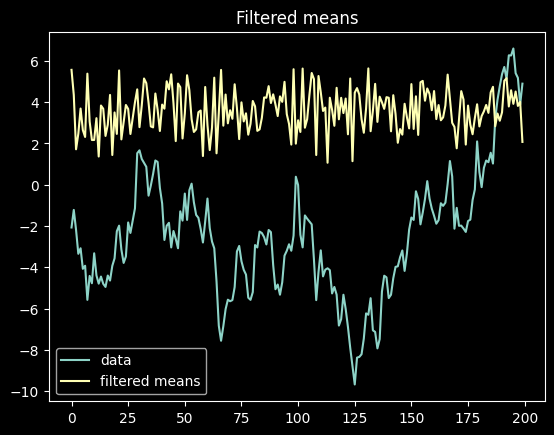

In [7]:
# Plot the filtered means
plt.plot(x, label='data')
plt.plot(alg.X, label='filtered means')
plt.title('Filtered means')
plt.legend()
plt.show()


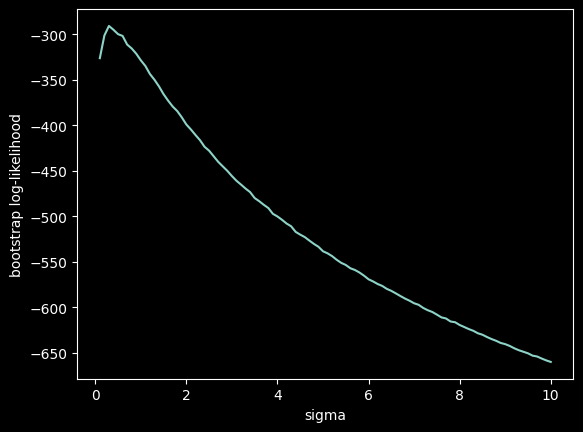

In [6]:
# Analyze likelihood for different parameter settings
def loglik(sigma):
    my_model = ToySSM(sigma=sigma)
    alg = particles.SMC(fk=ssm.Bootstrap(ssm=my_model, data=y), N=200)
    alg.run()
    return alg.logLt

sigmas = np.linspace(0.1, 10, 100)
loglik_values = [loglik(sigma) for sigma in sigmas]
plt.plot(sigmas, loglik_values)
plt.xlabel('sigma')
plt.ylabel('bootstrap log-likelihood')
plt.show()


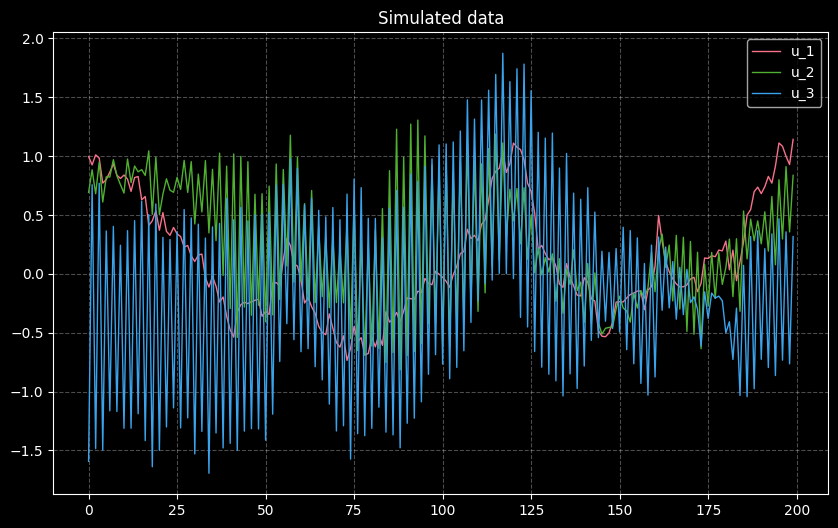

In [24]:
# plot the simulated data and the latent state Λ_t 
#plot u1 to u10 and Λ1 to Λ10
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
colors = sns.color_palette("husl", n)
for i in range(n):
    plt.plot([u[j][0,i] for j in range(len(u))], label=f'u_{i+1}', linewidth=1.0, color=colors[i])
plt.title("Simulated data")
plt.grid(alpha=0.3, linestyle='--')
# black background
plt.legend()
plt.show()




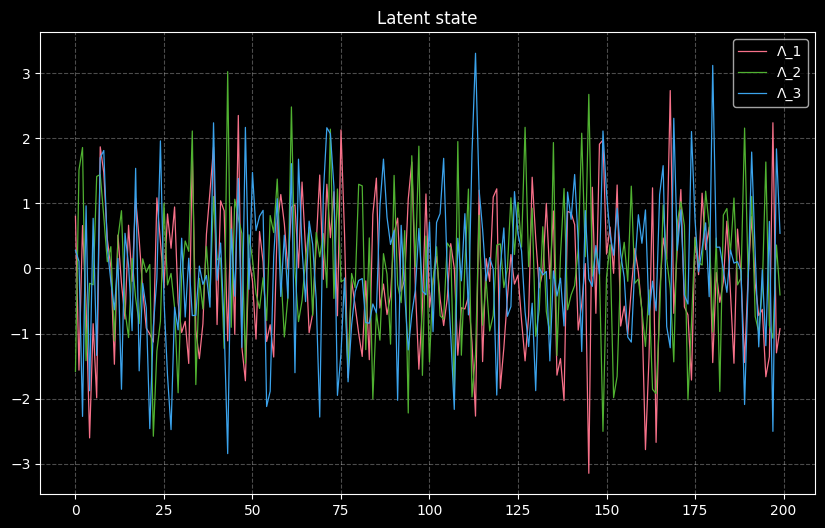

In [25]:
plt.figure(figsize=(10, 6))
plt.style.use('dark_background')
for i in range(n):
    plt.plot([Λ[j][0,i] for j in range(len(Λ))], label=f'Λ_{i+1}', linewidth=0.9, color=colors[i])
plt.title("Latent state")
plt.grid(alpha=0.3, linestyle='--')
plt.legend()
plt.show()


## Univariate Marginal Stochastic Volatility Model (skewness + leverage effect)

In this section we will implement the model and simulatae a bootstrap particle filter to estimate the latent variables of the model.
We will use two ways of implementation : 
- Using the `particles` library (see .py Script (with and without levrage effect)). In this way the boorstrap particle filter is already implemented in the library.
- Using from-scratch implementation of the bootstrap particle filter.

In [27]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from scipy.stats import invgamma, norm, t
from scipy.optimize import minimize
import matplotlib.pyplot as plt
import seaborn as sns
from typing import NamedTuple, Tuple, List
from tqdm.notebook import tqdm

In [59]:

class SVParams(NamedTuple):
    """Parameters for the SV model"""
    beta: float      # Regression parameter
    gamma: float     # Skewness parameter
    phi: float       # Persistence in volatility
    mu: float        # Long-run mean of log-volatility
    sigma: float     # Volatility of volatility
    rho: float       # Leverage correlation
    nu: float        # Degrees of freedom for Student's t
    
def simulate_sv(params: SVParams, T: int, W: np.ndarray = None) -> Tuple[np.ndarray, np.ndarray, np.ndarray]:
    """
    Simulate from the SV model
    
    Args:
        params: Model parameters
        T: Number of time periods
        W: Optional covariates matrix
    
    Returns:
        y: Observed returns
        h: Log-volatilities
        delta: Mixing variables
    """
    if W is None:
        W = np.ones((T, 1))  # Just intercept
        
    # Initialize arrays
    y = np.zeros(T)
    h = np.zeros(T+1)
    delta = np.zeros(T)
    
    # Initial condition for log-volatility
    h[0] = params.mu
    
    # Generate correlated normal innovations
    eps_y = np.random.normal(0, 1, T)
    eps_h = params.rho * eps_y + np.sqrt(1 - params.rho**2) * np.random.normal(0, 1, T)
    
    # Generate inverse gamma mixing variables
    delta = invgamma.rvs(params.nu/2, scale=params.nu/2, size=T)
    
    # Simulate process
    for t in range(T):
        # State equation
        h[t+1] = params.mu + params.phi * (h[t] - params.mu) + params.sigma * eps_h[t]
        
        # Observation equation
        y[t] = (W[t] @ np.array([params.beta]).reshape(-1,1)).item() + \
               params.gamma * delta[t] + \
               np.sqrt(delta[t] * np.exp(h[t])) * eps_y[t]
    
    return y, h[:-1], delta

def bootstrap_particle_filter(y: np.ndarray, params: SVParams, W: np.ndarray, 
                            N: int = 1000) -> Tuple[float, np.ndarray, dict]:
    """
    Bootstrap particle filter for SV model with diagnostics
    
    Returns:
        log_likelihood: Log-likelihood estimate
        filtered_h: Filtered estimates of log-volatility
        diagnostics: Dictionary containing filter diagnostics
    """
    T = len(y)
    particles = np.zeros((N, T+1))
    weights = np.ones(N) / N
    log_likelihood = 0
    filtered_h = np.zeros(T)
    
    # Diagnostics
    ESS_history = np.zeros(T)
    resampling_times = []
    
    # Initialize particles from prior
    particles[:, 0] = np.random.normal(params.mu, params.sigma/np.sqrt(1-params.phi**2), N)
    
    for t in range(T):
        # Propagate particles
        eps_h = np.random.normal(0, 1, N)
        particles[:, t+1] = params.mu + params.phi * (particles[:, t] - params.mu) + \
                           params.sigma * eps_h
        
        # Calculate weights
        delta = invgamma.rvs(params.nu/2, scale=params.nu/2, size=N)
        mean = W[t] @ np.array([params.beta]).reshape(-1,1) + params.gamma * delta
        std = np.sqrt(delta * np.exp(particles[:, t]))
        weights = norm.pdf(y[t], mean.flatten(), std)
        
        # Normalize weights
        weights = weights / np.sum(weights)
        
        # Calculate log-likelihood contribution
        log_likelihood += np.log(np.mean(weights))
        
        # Store filtered estimate
        filtered_h[t] = np.sum(weights * particles[:, t])
        
        # Calculate ESS
        ESS = 1 / np.sum(weights**2)
        ESS_history[t] = ESS
        
        # Resample if needed
        if ESS < N/2:
            indices = np.random.choice(N, N, p=weights)
            particles = particles[indices]
            weights = np.ones(N) / N
            resampling_times.append(t)
            
    diagnostics = {
        'ESS': ESS_history,
        'resampling_times': resampling_times,
        'particles': particles
    }
            
    return log_likelihood, filtered_h, diagnostics

def plot_diagnostics(diagnostics: dict, y: np.ndarray, h_true: np.ndarray, 
                    h_filtered: np.ndarray, delta: np.ndarray):
    """
    Plot particle filter diagnostics
    """
    fig, axes = plt.subplots(3, 1, figsize=(15, 12))
    
    # Plot ESS
    axes[0].plot(diagnostics['ESS'])
    axes[0].set_title('Effective Sample Size')
    axes[0].axhline(y=len(diagnostics['particles'])/2, color='r', linestyle='--')
    
    # Plot true vs filtered volatility
    axes[1].plot(h_true, label='True', color='orange')
    axes[1].plot(h_filtered, label='Filtered', color='navy')
    axes[1].set_title('True vs Filtered Log-Volatility')
    axes[1].legend()
    
    # Plot returns with volatility bands
    vol_bands = np.exp(h_filtered/2) * np.sqrt(delta)
    axes[2].plot(y, 'bo', alpha=0.5, label='Observed Returns') # Observed returns
    axes[2].plot(2*vol_bands, '--', alpha=0.9, label='±2 Volatility Bands', color='navy')
    axes[2].plot(-2*vol_bands, '--', alpha=0.9, color='navy')
    axes[2].set_title('Returns with ±2 Filtered Volatility Bands')
    axes[2].legend()
    plt.tight_layout()
    return fig


In [60]:
true_params = SVParams(
        beta=0.5,    # Regression parameter
        gamma=0.1,   # Skewness parameter
        phi=0.98,    # Persistence in volatility
        mu=0.0,      # Long-run mean of log-volatility
        sigma=0.15,  # Volatility of volatility
        rho=-0.7,    # Leverage correlation
        nu=10.0      # Degrees of freedom
)

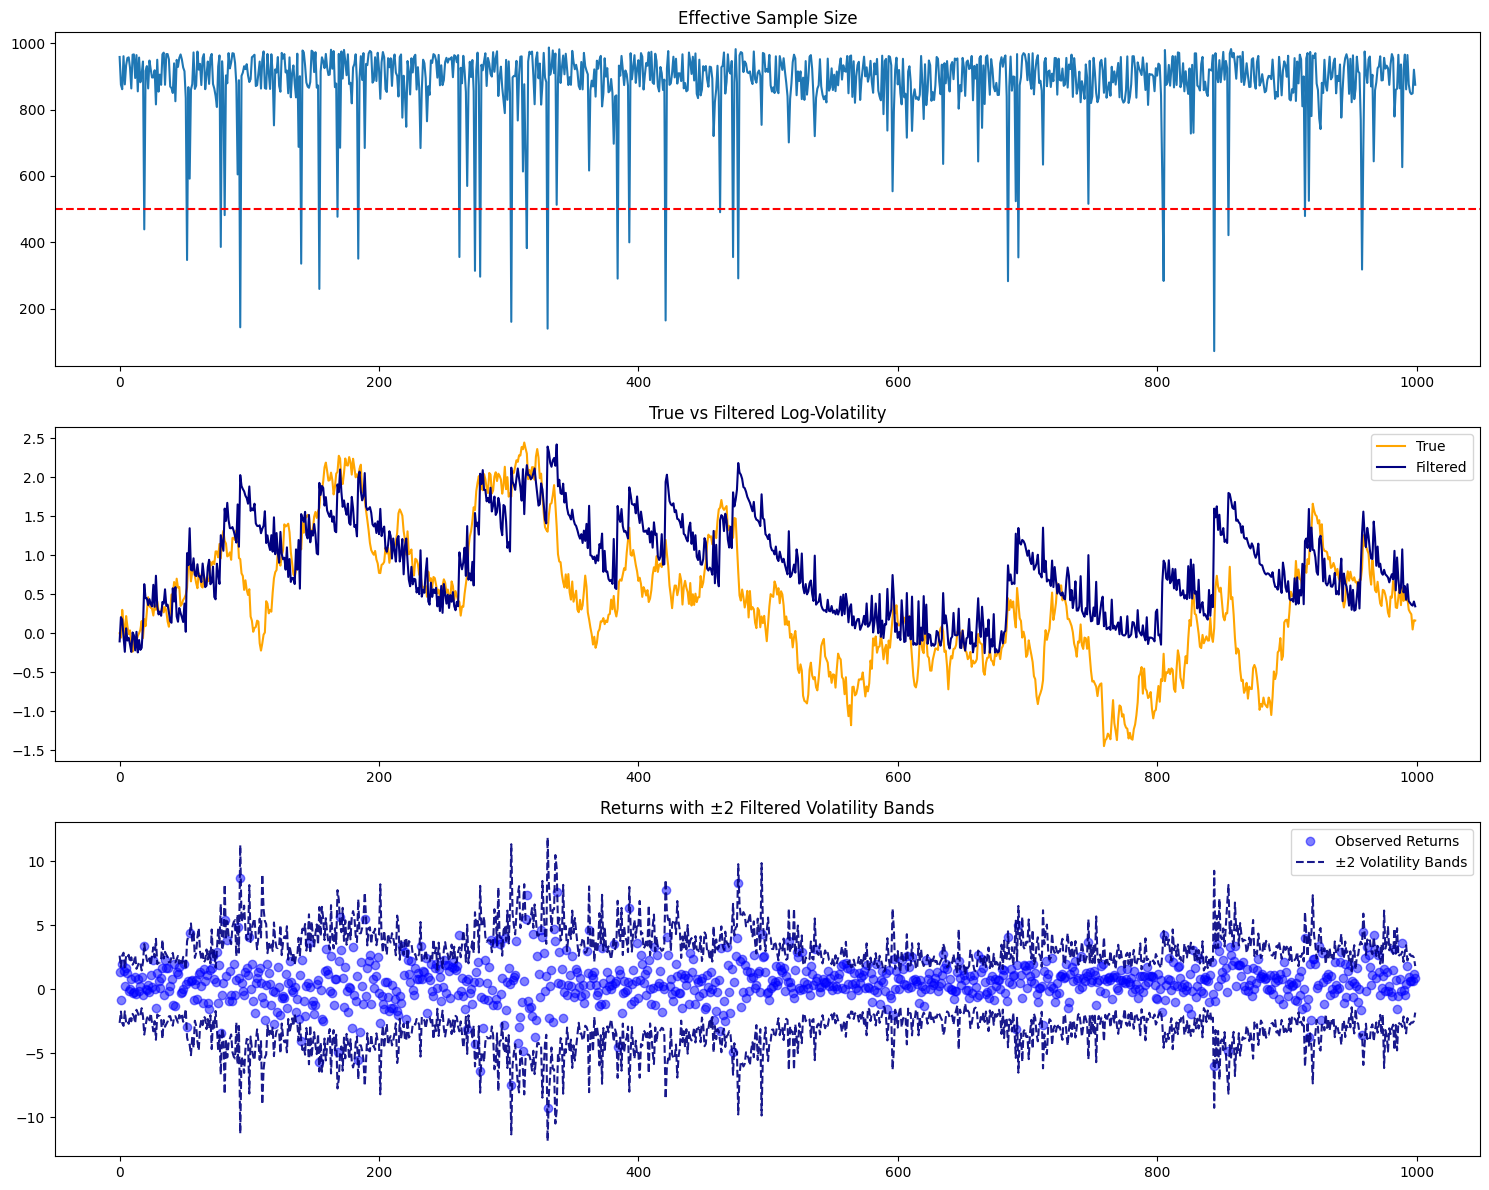

In [61]:
# Simulate data
T = 1000
y, h_true, delta = simulate_sv(true_params, T)
W = np.ones((T, 1))  # Just intercept

# Run particle filter
log_lik, h_filtered, diagnostics = bootstrap_particle_filter(y, true_params, W, N=1000) # N is number of particles
# Plot diagnostics
plt.style.use('default')
fig_diag = plot_diagnostics(diagnostics, y, h_true, h_filtered, delta=delta)
#plt.savefig('diagnostics2.png')

plt.show()

- Lets now apply the bootstrap filter on our equities data, and see how it performs.

  0%|          | 0/25 [00:00<?, ?it/s]

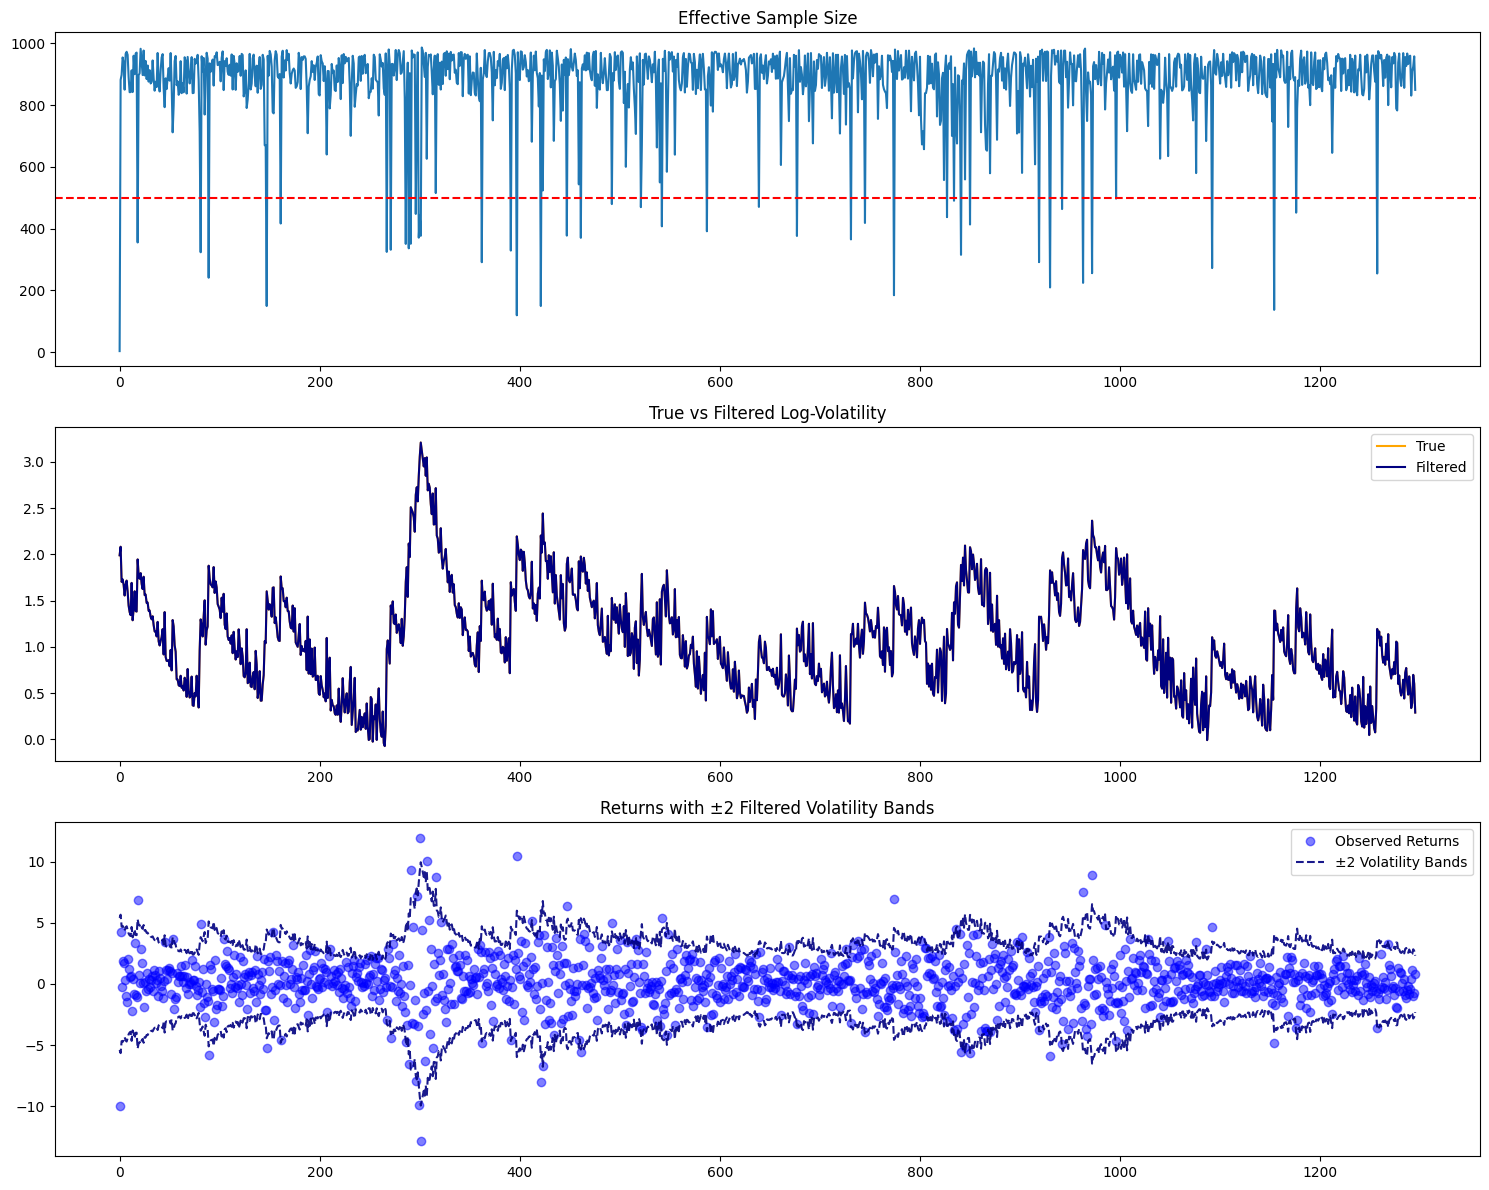

In [62]:
data = pd.read_csv('../Data/daily_equity_returns_recent.csv', index_col=0)
data.dropna(axis=0, inplace=True)
real_data = data.values
real_data.shape
# Loop through each series in your data

results = []
for i in tqdm(range(real_data.shape[1]//4)):
    y_series = real_data[:, i]  # Select the i-th series

    # create the W matrix
    W = np.ones((len(y_series), 1))  # Just intercept
    
    
    # Run particle filter on each series
    log_lik, h_filtered, diagnostics = bootstrap_particle_filter(y_series, true_params, W, N=1000)
    
    # Store the results
    results.append({
        'log_likelihood': log_lik,
        'filtered_h': h_filtered,
        'diagnostics': diagnostics
    })


AAPL
-----------------
Log-likelihood: -8952.450841560943


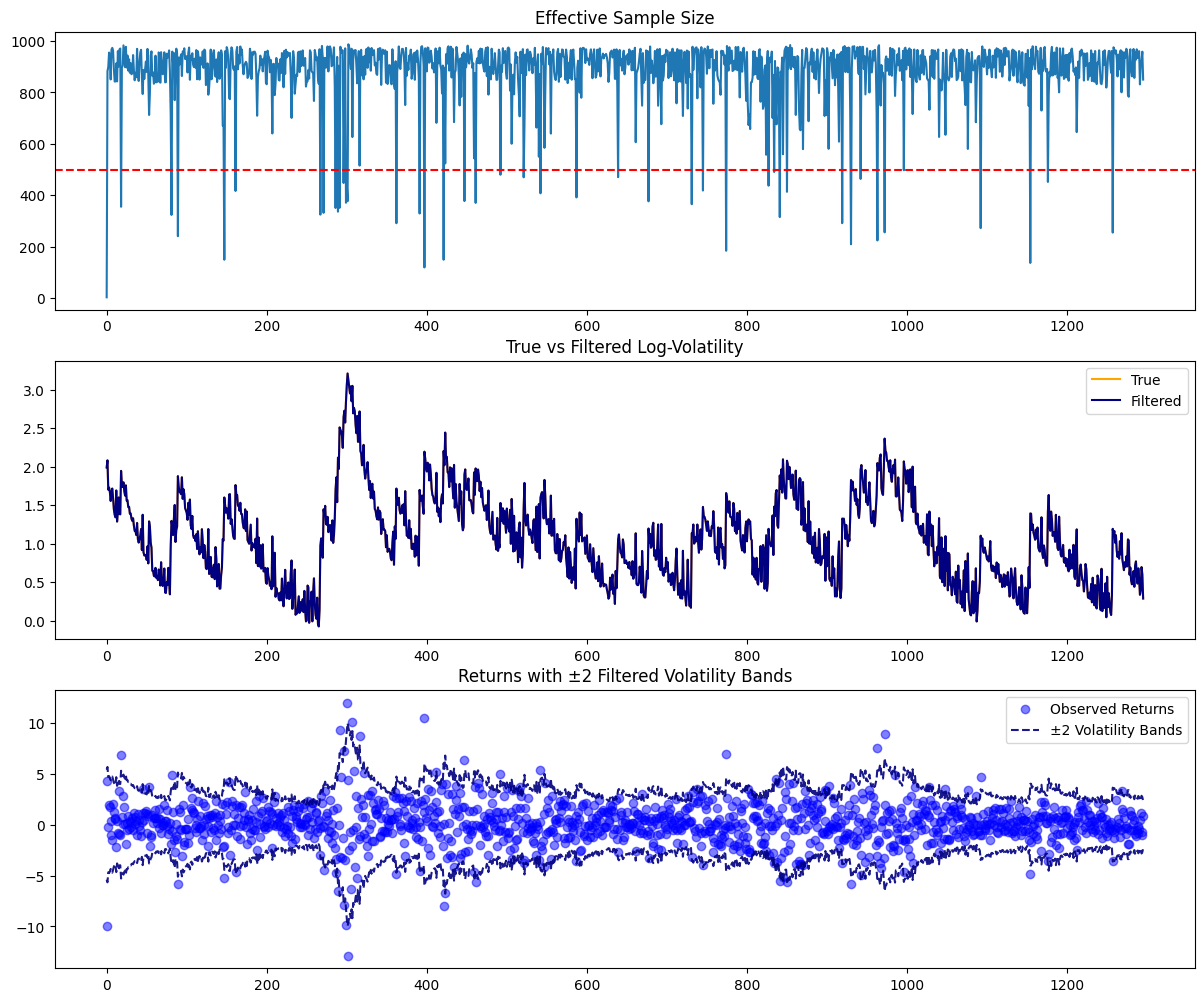

In [68]:
# Plot diagnostics for the first series which is 'AAPL'
print('AAPL')
print("-----------------")
print('Log-likelihood:', results[0]['log_likelihood'])
fig = plot_diagnostics(results[0]['diagnostics'], real_data[:, 0], results[0]['filtered_h'], results[0]['filtered_h'], delta=np.ones(len(real_data)))
# change the size of the figure
fig.set_size_inches(12, 10)
#plt.savefig('diagnostics_series1_real_data.png')
plt.show()

NVDA
-----------------
Log-likelihood: -8952.450841560943


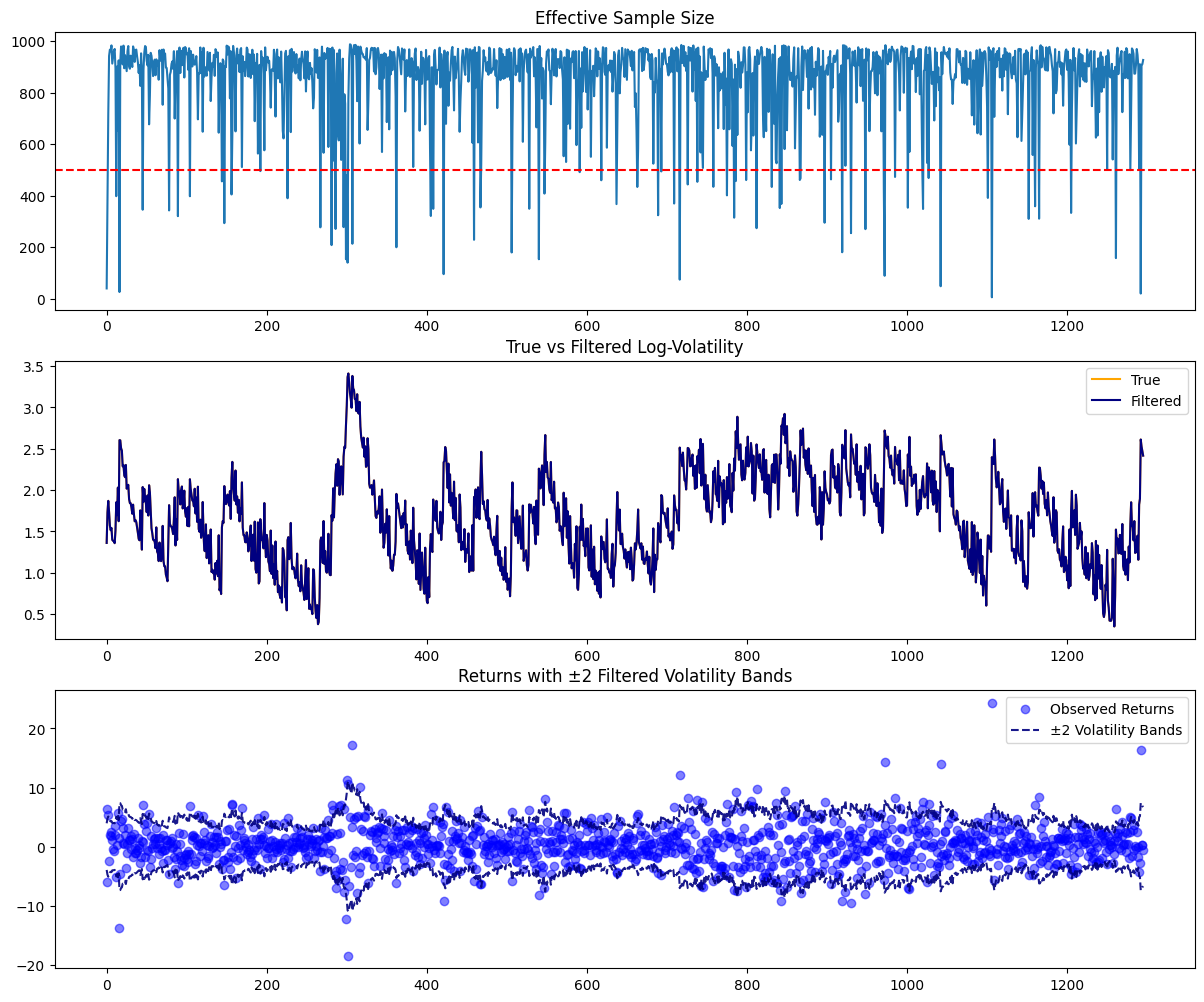

In [71]:
# for the second series which is 'NVDA'
print('NVDA')
print("-----------------")
print('Log-likelihood:', results[1]['log_likelihood'])
fig = plot_diagnostics(results[1]['diagnostics'], real_data[:, 1], results[1]['filtered_h'], results[1]['filtered_h'], delta=np.ones(len(real_data)))
fig.set_size_inches(12, 10)
#plt.savefig('diagnostics_series2_real_data.png')
plt.show()


- Now we will study the effect of the parameters on the liklihood. We will also estimate the parameters using MLE.

$\boxed{\text{See this part in the other notebook SVwithMLE.ipynb}}$

## Particle Gibbs Sampler 

    First Implementation of PGS : (see .py Script)

In [88]:
import numpy as np
from scipy import stats
from typing import Tuple, List, Optional

class ParticleGibbsSampler:
    def __init__(self, 
                 T: int,
                 M: int = 100,  # Number of particles (paper uses M=100)
                 mu_prior: Tuple[float, float] = (0.4, 2.0),  # N(0.4, 2) prior for mu
                 phi_prior: Tuple[float, float] = (0.985, 0.001),  # N(0.985, 0.001) for phi
                 sigma_prior: Tuple[float, float] = (20, 0.25)):  # IG(20, 0.25) for sigma
        self.T = T  # Time series length
        self.M = M  # Number of particles
        
        # Prior parameters
        self.mu_prior = mu_prior
        self.phi_prior = phi_prior
        self.sigma_prior = sigma_prior
        
    def proposal_distribution(self, 
                            lambda_prev: float, 
                            ut: float, 
                            Xt: np.ndarray, 
                            zt: float, 
                            zeta_t: float, 
                            theta: dict) -> float:
        """
        Proposal distribution q(λ_t|λ_{t-1}, u_t, X_t, z_t, ζ_t, θ)
        Using a simple random walk proposal for demonstration
        """
        mu, phi, sigma = theta['mu'], theta['phi'], theta['sigma']
        mean = phi * lambda_prev + (1 - phi) * mu
        return np.random.normal(mean, np.sqrt(sigma))
    
    def calculate_importance_weights(self,
                                  particles: np.ndarray,
                                  prev_particles: np.ndarray,
                                  ut: float,
                                  Xt: np.ndarray,
                                  zt: float,
                                  zeta_t: float,
                                  theta: dict) -> np.ndarray:
        """
        Calculate importance weights for particles
        """
        mu, phi, sigma = theta['mu'], theta['phi'], theta['sigma']
        
        # Calculate transition density p(λ_t|λ_{t-1}, θ)
        transition_density = stats.norm.pdf(
            particles, 
            loc=phi * prev_particles + (1 - phi) * mu,
            scale=np.sqrt(sigma)
        )
        
        # Calculate likelihood p(u_t|z_t, X_t, λ_t, ζ_t, θ)
        # Simplified likelihood for demonstration
        likelihood = stats.norm.pdf(ut, loc=particles * zt, scale=np.sqrt(zeta_t))
        
        # Calculate proposal density
        proposal_density = stats.norm.pdf(
            particles,
            loc=phi * prev_particles + (1 - phi) * mu,
            scale=np.sqrt(sigma)
        )
        
        # Return normalized weights
        weights = (likelihood * transition_density) / proposal_density
        return weights / np.sum(weights)
    
    def conditional_resampling(self,
                             particles: np.ndarray,
                             weights: np.ndarray,
                             reference_particle: float) -> np.ndarray:
        """
        Conditional multinomial resampling ensuring reference particle survives
        """
        M = len(particles)
        indices = np.zeros(M, dtype=int)
        
        # Always keep the reference particle
        indices[0] = 0
        particles[0] = reference_particle
        
        # Resample remaining M-1 particles
        remaining_indices = np.random.choice(
            M, size=M-1, p=weights, replace=True
        )
        indices[1:] = remaining_indices
        
        return particles[indices]
    
    def backwards_sampling(self,
                         particles_history: List[np.ndarray],
                         weights_history: List[np.ndarray],
                         theta: dict) -> np.ndarray:
        """
        Backward sampling pass to draw trajectory
        """
        T = len(particles_history)
        trajectory = np.zeros(T)
        
        # Sample last state
        last_idx = np.random.choice(self.M, p=weights_history[-1])
        trajectory[-1] = particles_history[-1][last_idx]
        
        # Backward pass
        for t in range(T-2, -1, -1):
            mu, phi, sigma = theta['mu'], theta['phi'], theta['sigma']
            
            # Calculate backwards weights
            back_weights = weights_history[t] * stats.norm.pdf(
                trajectory[t+1],
                loc=phi * particles_history[t] + (1 - phi) * mu,
                scale=np.sqrt(sigma)
            )
            back_weights /= np.sum(back_weights)
            
            # Sample state
            idx = np.random.choice(self.M, p=back_weights)
            trajectory[t] = particles_history[t][idx]
            
        return trajectory
    
    def sample_path(self,
                   ut: np.ndarray,
                   Xt: np.ndarray,
                   zt: np.ndarray,
                   zeta_t: np.ndarray,
                   theta: dict,
                   reference_path: Optional[np.ndarray] = None) -> np.ndarray:
        """
        Run particle Gibbs sampler to draw a new path
        """
        particles_history = []
        weights_history = []
        
        # Initialize particles
        particles = np.random.normal(
            theta['mu'],
            np.sqrt(theta['sigma'] * 100),  # Inflated initial variance
            size=self.M
        )
        
        if reference_path is not None:
            particles[0] = reference_path[0]
            
        for t in range(self.T):
            # Store previous particles
            prev_particles = particles.copy()
            
            # Propose new particles (except reference)
            if reference_path is not None:
                particles[0] = reference_path[t]
            for m in range(1 if reference_path is not None else 0, self.M):
                particles[m] = self.proposal_distribution(
                    prev_particles[m], ut[t], Xt[t], zt[t], zeta_t[t], theta
                )
                
            # Calculate weights
            weights = self.calculate_importance_weights(
                particles, prev_particles, ut[t], Xt[t], zt[t], zeta_t[t], theta
            )
            
            # Conditional resampling
            if reference_path is not None:
                particles = self.conditional_resampling(particles, weights, reference_path[t])
            
            # Store particles and weights
            particles_history.append(particles.copy())
            weights_history.append(weights.copy())
            
        # Backward sampling
        return self.backwards_sampling(particles_history, weights_history, theta)

def run_particle_gibbs(ut: np.ndarray,
                      Xt: np.ndarray,
                      zt: np.ndarray,
                      zeta_t: np.ndarray,
                      n_iterations: int = 1000) -> np.ndarray:
    """
    Run the complete Particle Gibbs sampling procedure
    """
    T = len(ut)
    sampler = ParticleGibbsSampler(T)
    
    # Initialize parameters
    theta = {
        'mu': np.random.normal(0.4, np.sqrt(2.0)),
        'phi': np.random.normal(0.985, np.sqrt(0.001)),
        'sigma': 1/np.random.gamma(20, 1/0.25)
    }
    
    # Initialize path
    current_path = np.random.normal(theta['mu'], np.sqrt(theta['sigma']), size=T)
    
    # Store samples
    samples = np.zeros((n_iterations, T))
    
    # Run sampler
    for i in tqdm(range(n_iterations)):
        # Sample new path
        current_path = sampler.sample_path(ut, Xt, zt, zeta_t, theta, current_path)
        samples[i] = current_path
        
        # # Update parameters (theta) by  sampling from the full conditionals
        # mu_posterior = (np.sum(current_path) + np.sum(Xt)) / (T + 1)
        # phi_posterior = np.random.normal(
        #     np.mean(current_path[1:] - mu_posterior),
        #     np.sqrt(1 / np.sum((current_path[1:] - mu_posterior)**2))
        # )
        # sigma_posterior = 1 / np.random.gamma(
        #     20 + T/2,
        #     1 / (0.25 + 0.5 * np.sum((current_path[1:] - phi_posterior * current_path[:-1])**2))
        # )

        # # Update parameters
        # theta['mu'] = mu_posterior
        # theta['phi'] = phi_posterior
        # theta['sigma'] = sigma_posterior
        
    return samples

In [89]:
# Example usage
T = 200  # Number of time points
ut = np.random.randn(T)  # Your data
Xt = np.random.randn(T)  # Your covariates
zt = np.random.randn(T)  # Common factors
zeta_t = np.random.gamma(5, 1, T)  # Mixing variables

# Run sampler
samples = run_particle_gibbs(ut, Xt, zt, zeta_t, n_iterations=100)

  0%|          | 0/100 [00:00<?, ?it/s]

In [90]:
samples.shape

(100, 200)

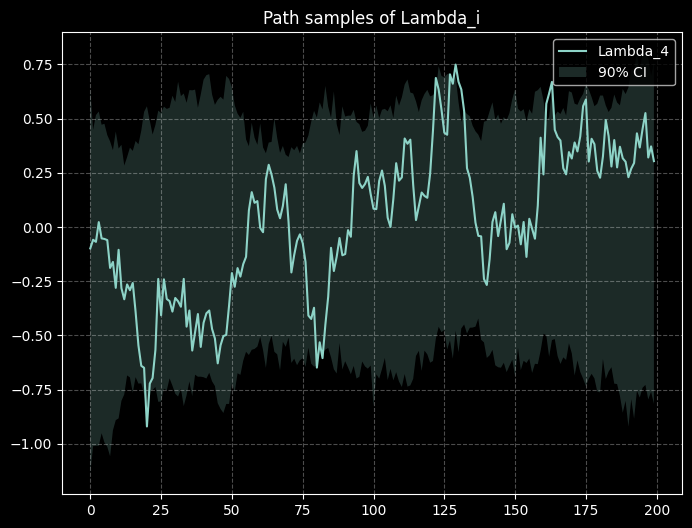

In [96]:
# Plot the path samples
plt.figure(figsize=(8, 6))
plt.style.use('dark_background')
for i in range(3,4):
    plt.plot(samples[i].T, label=f"Lambda_{i+1}")
    plt.fill_between(np.arange(T), np.percentile(samples, 5, axis=0), np.percentile(samples, 95, axis=0), alpha=0.2, label='90% CI')
plt.title("Path samples of Lambda_i")
plt.legend()
plt.grid(alpha=0.3, linestyle='--')
plt.show()


    Sophisticated Implementation : (see FctorLoadingPGS.py Script)

In [97]:
import numpy as np
from scipy import stats
from typing import Tuple, List, Optional
from tqdm.notebook import tqdm

class FactorLoadingParticleGibbs:
    def __init__(self, 
                 n: int,  # Number of series
                 p: int,  # Number of factors
                 T: int,  # Time series length
                 M: int = 100):  # Number of particles
        self.n = n
        self.p = p
        self.T = T
        self.M = M
        self.np = n * p
        
    def initialize_state(self, theta: dict) -> np.ndarray:
        """
        Initialize state vector following the paper's specification
        λᵢ,₁ ~ N(μᵢ, 100*Σᵢᵢ)
        """
        mu = theta['mu']  # np x 1
        sigma = theta['sigma']  # np x 1 (diagonal elements)
        
        # Initialize with inflated variance as per paper
        return np.random.normal(
            mu.reshape(-1),
            np.sqrt(100 * sigma.reshape(-1))
        )
    
    def transition_density(self,
                         lambda_t: np.ndarray,
                         lambda_prev: np.ndarray,
                         theta: dict) -> float:
        """
        Transition density p with diagonal phi and sigma.
        """
        mu = theta['mu']  # np x 1
        phi = theta['phi']  # np x 1 (diagonal elements of Φλ)
        sigma = theta['sigma']  # np x 1 (diagonal elements of Σ)
        
        mean = phi * lambda_prev + (1 - phi) * mu
        return np.sum(stats.norm.logpdf(lambda_t, mean, np.sqrt(sigma)))
    
    def observation_density(self,
                          ut: np.ndarray,
                          Xt: np.ndarray,
                          zt: np.ndarray,
                          zeta_t: float,
                          lambda_t: np.ndarray,
                          theta: dict) -> float:
        """
        Observation density p(uₜ|zₜ,Xₜ,λₜ,ζₜ,θ)
        """
        # Reshape lambda_t to n x p matrix
        lambda_mat = lambda_t.reshape(self.n, self.p)
        
        # Calculate scaled loadings as per equation (6)
        lambda_norm = np.sum(lambda_mat**2, axis=1, keepdims=True)
        lambda_scaled = lambda_mat / np.sqrt(1 + lambda_norm)
        
        # Calculate likelihood based on model specification
        # This is a simplified version - adjust based on your specific copula choice
        return np.sum(stats.norm.logpdf(ut, np.dot(lambda_scaled, zt), np.sqrt(zeta_t)))
    
    def propose_particles(self,
                         lambda_prev: np.ndarray,
                         theta: dict) -> np.ndarray:
        """
        Proposal distribution q(λₜ|λₜ₋₁,uₜ,Xₜ,zₜ,ζₜ,θ)
        """
        mu = theta['mu']
        phi = theta['phi']
        sigma = theta['sigma']
        
        # Use transition density as proposal
        mean = phi * lambda_prev + (1 - phi) * mu
        return np.random.normal(mean, np.sqrt(sigma))
    
    def conditional_resampling(self,
                             particles: np.ndarray,
                             weights: np.ndarray,
                             reference_particle: np.ndarray) -> np.ndarray:
        """
        Conditional multinomial resampling ensuring reference trajectory survives
        """
        M = self.M
        resampled = np.zeros((M, self.np))
        
        # Keep reference particle
        resampled[0] = reference_particle
        
        # Resample M-1 particles
        indices = np.random.choice(M, size=M-1, p=weights)
        resampled[1:] = particles[indices]
        
        return resampled
    
    def backward_sampling(self,
                         particles_history: List[np.ndarray],
                         weights_history: List[np.ndarray],
                         theta: dict) -> np.ndarray:
        """
        Backward sampling to draw trajectory
        """
        trajectory = np.zeros((self.T, self.np))
        
        # Sample last state
        idx = np.random.choice(self.M, p=weights_history[-1])
        trajectory[-1] = particles_history[-1][idx]
        
        # Backward pass
        for t in range(self.T-2, -1, -1):
            back_weights = np.zeros(self.M)
            
            # Calculate backward weights
            for m in range(self.M):
                back_weights[m] = weights_history[t][m] + \
                                self.transition_density(trajectory[t+1],
                                                      particles_history[t][m],
                                                      theta)
                                
            # Normalize weights
            back_weights = np.exp(back_weights - np.max(back_weights))
            back_weights /= np.sum(back_weights)
            
            # Sample state
            idx = np.random.choice(self.M, p=back_weights)
            trajectory[t] = particles_history[t][idx]
            
        return trajectory
    
    def sample_path(self,
                   ut: np.ndarray,  # T x n matrix of observations
                   Xt: np.ndarray,  # T x n x k matrix of covariates
                   zt: np.ndarray,  # T x p matrix of factors
                   zeta_t: np.ndarray,  # T vector of mixing variables
                   theta: dict,
                   reference_path: Optional[np.ndarray] = None) -> np.ndarray:
        """
        Run particle Gibbs sampler for one complete path
        """
        particles_history = []
        weights_history = []
        
        # Initialize particles
        particles = np.array([self.initialize_state(theta) for _ in range(self.M)])
        
        if reference_path is not None:
            particles[0] = reference_path[0]
            
        for t in range(self.T):
            # Store previous particles
            prev_particles = particles.copy()
            
            # Propose new particles (except reference)
            if reference_path is not None:
                particles[0] = reference_path[t]
            for m in range(1 if reference_path is not None else 0, self.M):
                particles[m] = self.propose_particles(prev_particles[m], theta)
            
            # Calculate weights
            log_weights = np.zeros(self.M)
            for m in range(self.M):
                # Numerator: p(uₜ|zₜ,Xₜ,λₜ,ζₜ,θ)p(λₜ|λₜ₋₁,θ)
                log_weights[m] = self.observation_density(ut[t], Xt[t], zt[t], zeta_t[t], 
                                                        particles[m], theta)
                log_weights[m] += self.transition_density(particles[m], prev_particles[m], theta)
                
                # Denominator: proposal density (if different from transition)
                # Not needed here as we use transition density as proposal
            
            # Normalize weights
            weights = np.exp(log_weights - np.max(log_weights))
            weights /= np.sum(weights)
            
            # Conditional resampling
            if reference_path is not None:
                particles = self.conditional_resampling(particles, weights, reference_path[t])
            
            particles_history.append(particles.copy())
            weights_history.append(weights.copy())
            
        # Backward sampling
        return self.backward_sampling(particles_history, weights_history, theta)

def run_factor_loading_sampler(ut: np.ndarray,
                             Xt: np.ndarray,
                             zt: np.ndarray,
                             zeta_t: np.ndarray,
                             n: int,
                             p: int,
                             n_iterations: int = 1000) -> np.ndarray:
    """
    Run complete Particle Gibbs sampling for factor loadings
    Returns: Array of shape (n_iterations, T, n*p) containing sampled paths
    """
    T = len(ut)
    sampler = FactorLoadingParticleGibbs(n, p, T)
    
    # Initialize parameters (could be passed as arguments)
    theta = {
        'mu': np.random.normal(0.4, np.sqrt(2.0), size=n*p),
        'phi': np.random.normal(0.985, np.sqrt(0.001), size=n*p),
        'sigma': 1/np.random.gamma(20, 1/0.25, size=n*p)
    }
    
    # Initialize path
    current_path = np.random.normal(
        theta['mu'], 
        np.sqrt(theta['sigma']), 
        size=(T, n*p)
    )
    
    # Store samples
    samples = np.zeros((n_iterations, T, n*p))
    
    # Run sampler
    # Add tqdm progress bar in yellow for sampling iterations
    for i in tqdm(range(n_iterations), desc='Sampling', colour='green'):
        #print(i)
        current_path = sampler.sample_path(ut, Xt, zt, zeta_t, theta, current_path)
        samples[i] = current_path
    return samples

In [98]:
# Example setup
n = 100  # number of series
p = 2    # number of factors
T = 200 # time points
k = 1    # number of covariates

# Your data
ut = np.random.randn(T, n)  # Transformed observations
Xt = np.random.randn(T, n, k)  # Covariates
zt = np.random.randn(T, p)  # Factors
zeta_t = np.random.gamma(5, 1, T)  # Mixing variables

# Run sampler
samples = run_factor_loading_sampler(ut, Xt, zt, zeta_t, n, p, n_iterations=100)

Sampling:   0%|          | 0/10 [00:00<?, ?it/s]

In [99]:
samples.shape # (n_iterations, T, n*p)

(10, 200, 200)

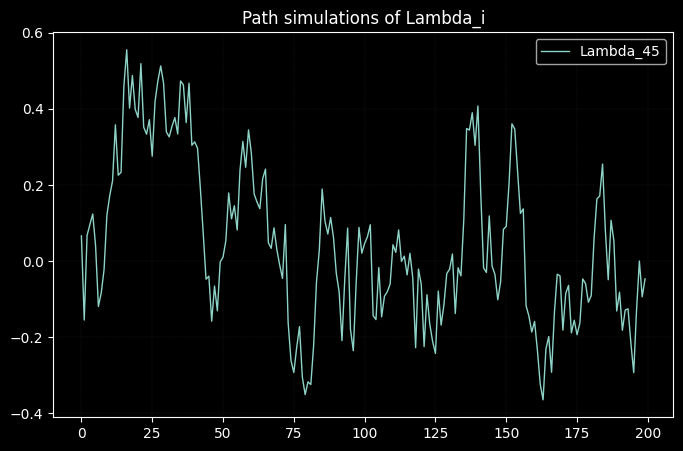

In [124]:
# Plot the path samples
plt.figure(figsize=(8, 5))
plt.style.use('dark_background')
for i in range(44, 45):
    for j in range(1):
        plt.plot(samples[j, :, i], label=f"Lambda_{i+1}", alpha=1, linewidth=1.0)
plt.title("Path simulations of Lambda_i")
plt.legend()
plt.grid(alpha=0.3, linestyle='--', color='gray', linewidth=0.2)
plt.show()


In [132]:
returns_data = pd.read_csv('../Data/daily_equity_returns_recent.csv', index_col=0)
returns_data.dropna(axis=0, inplace=True)
returns_data.head()

,AAPL,NVDA,MSFT,GOOGL,AMZN,GOOG,META,TSLA,AVGO,DELL,...,ADI,CB,NKE,SBUX,UPS,MDT,VRTX,MMC,LRCX,INTC
2019-01-03 00:00:00,-9.960746,-6.041690,-3.678803,-2.769564,-2.524150,-2.848404,-2.903878,-3.147171,-8.895103,-4.223279,...,-6.040504,-2.058312,-1.768832,-4.337683,-2.839219,-2.809387,-0.213314,-1.303121,-4.822874,-5.501290
2019-01-04 00:00:00,4.268917,6.406761,4.650938,5.129344,5.006400,5.378620,4.713832,5.769739,0.982864,1.972091,...,2.427872,2.991898,2.611703,3.315451,3.483312,3.136320,5.478533,2.448390,4.884898,6.136229
2019-01-07 00:00:00,-0.222566,5.294080,0.127542,-0.199418,3.435341,-0.216680,0.072483,5.436124,2.036604,0.651875,...,0.628839,-0.809951,1.433328,0.000000,-0.337600,-6.444999,1.823978,0.437935,0.890926,0.465900
2019-01-08 00:00:00,1.906304,-2.489535,0.725056,0.878321,1.661236,0.738490,3.245201,0.116428,-0.802587,1.187393,...,2.439607,-0.769451,1.333861,0.078655,0.010251,0.703452,1.330677,0.685182,-1.694309,0.632368
2019-01-09 00:00:00,1.698149,1.966657,1.429930,-0.342750,0.171435,-0.150514,1.192729,0.948263,4.324972,0.149364,...,2.534011,1.250188,-0.182454,0.408672,0.513251,1.529586,2.306527,0.086597,5.163221,0.565556


In [133]:
returns_data = returns_data.values
returns_data.shape

(1296, 100)

  0%|          | 0/5 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

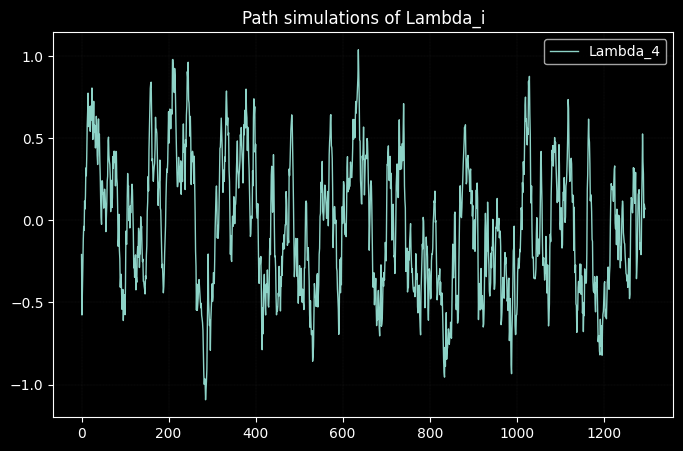

In [ ]:
# Apply this Gibbs sampler to the real data

# Loop through each series in your data
results = []
for i in tqdm(range(5)):
    y_series = returns_data[:, i]  # Select the i-th series

    # create the W matrix
    W = np.ones((len(y_series), 1))  # Just intercept
    
    # Run particle filter on each series
    samples = run_particle_gibbs(y_series, W, W, W, n_iterations=20)
    
    # Store the results
    results.append(samples)


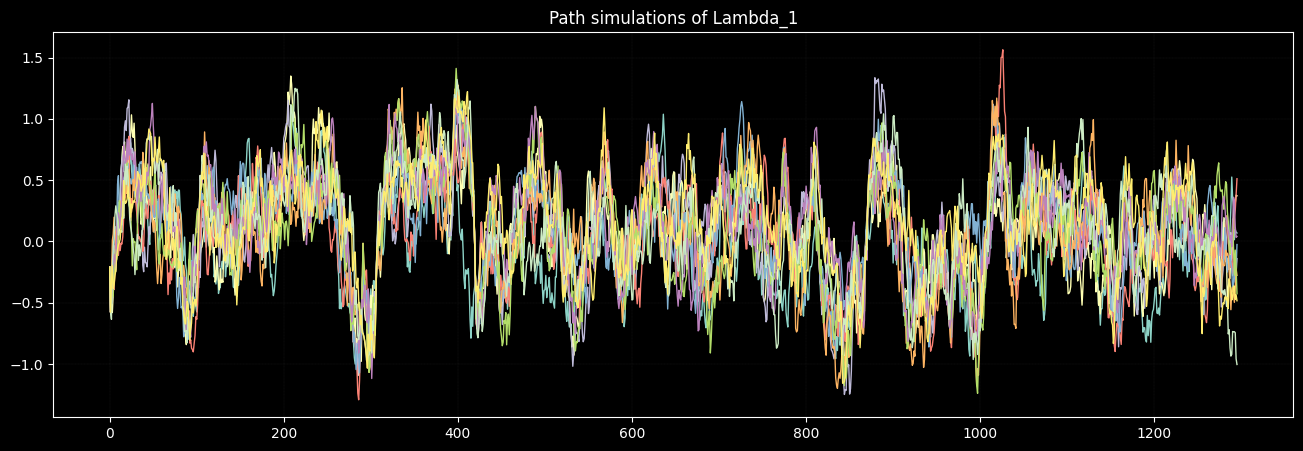

In [139]:
# Plot the path samples
plt.figure(figsize=(16, 5))
plt.style.use('dark_background')
for i in range(1):
    for j in range(10):
        plt.plot(results[0][j], label=f"Lambda_{i+1}", alpha=1, linewidth=1.0)
plt.title("Path simulations of Lambda_1")
#plt.legend()
plt.grid(alpha=0.3, linestyle='--', color='gray', linewidth=0.2)
plt.show()